Мартирсоян Завен  
martirosian.z@mail.ru

# Практика №3

Теперь в качестве акустической модели мы будем использовать простой DNN классификатор. На каждом кадре записи мы будем подавать его вектор признаков на DNN, которая будет выдавать "распределение вероятностей" по фонемам. Далее это распределение мы будем использовать в нашем алгоритме распознавания по словарю. Схема работы такого классификатора представлена ниже: 

![](https://drive.google.com/uc?export=view&id=1dv0VuE8DIoKXETbvnZq2PMixkWMCJOxr)

### Bootstrap

In [1]:
!gdown --id '1meikF0XqBUnVZKoY3160MQ0R25lq-EMu'
!gdown --id '1f0LkW6I3Q5CnOThuNFAJ9umgnb2eU4Ox'

!unzip -q lab2.zip
!unzip -q train_librispeech_10h.zip
!mv lab2 lab3
!mv train_librispeech_10h lab3/data
!rm -rf lab2.zip sample_data train_librispeech_10h.zip
%cd lab3

Downloading...
From: https://drive.google.com/uc?id=1meikF0XqBUnVZKoY3160MQ0R25lq-EMu
To: /content/lab2.zip
100% 1.66M/1.66M [00:00<00:00, 26.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1f0LkW6I3Q5CnOThuNFAJ9umgnb2eU4Ox
To: /content/train_librispeech_10h.zip
679MB [00:07, 94.5MB/s]
/content/lab3


In [2]:
import os
import numpy as np
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa, librosa.display
import torch
import torch.nn as nn
import torch.functional as F


%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
# загрузка списка допустимых фонем:
def load_phones_dict(phones_file):
    phones_dict = {}
    with open(phones_file, encoding='utf-8') as fn:
        for index, line in enumerate(fn):
            phones_dict[line.strip()] = index
    return phones_dict

# загрузка покадровой фонемной разметки в словарь:
def load_phone_aligment(aligment_file):
    ali_dict = {}
    with open(aligment_file, encoding='utf-8') as fn:
        for line in fn:
            line = line.strip().split()
            ali_dict[line[0]] = line[1:]
    return ali_dict

# подсчет акустиеских признаков для записей из папки:
def load_data_dict(dir_path, count=None):
    data_dict = {}
    step = 0
    for wav_name in tqdm(os.listdir(dir_path)):
        x, sr = librosa.load(os.path.join(dir_path, wav_name), sr=None) 
        mfcc = librosa.feature.mfcc(x, sr=sr, n_mfcc=13, 
                                    n_fft=int(sr * 0.025),
                                    hop_length=int(sr * 0.01))
        step += 1
        if count and step == count:
            print(f'Early stop at {step}th file..')
            break
        data_dict[wav_name.split('.')[0]] = mfcc.T  
    return data_dict


phones_file = 'data/train_librispeech_10h/phones'
phones_dict = load_phones_dict(phones_file)

ali_file = 'data/train_librispeech_10h/ali_phones.txt'
ali_dict = load_phone_aligment(ali_file)

train_records_dir = 'data/train_librispeech_10h/wav_dir'
feats_dict = load_data_dict(train_records_dir, count=1000)

Early stop at 1000th file..


### Априорная вероятность:

![](https://drive.google.com/uc?export=view&id=1WhjclhXm2POYsCgvxp3iAIOvT9F_k8If)

In [4]:
# объединение кадров признаков с соответствующими им фонемам:
def combain_data(ali_dict, feats_dict, phones_dict, side_context=1):
    data_list = []
    priors_list = [0] * len(phones_dict)
    for file_name in feats_dict.keys():
        file_feats = feats_dict[file_name]
        file_feats = np.vstack((file_feats[:side_context], file_feats))
        file_feats = np.vstack((file_feats, file_feats[-side_context:]))
        file_ali = ali_dict[file_name]
        for frame in range(side_context, min(len(file_feats), len(file_ali))):
            data_list.append(np.append(
                file_feats[frame - side_context : frame + side_context + 1].ravel(), 
                phones_dict[file_ali[frame]]))
            priors_list[phones_dict[file_ali[frame]]] += 1
    return data_list, np.array(priors_list)/sum(priors_list)

side_context = 3
data_list, priors_list = combain_data(ali_dict, feats_dict, phones_dict, side_context)
data_list = np.random.permutation(data_list)

In [5]:
class CommonDataSet():

    def __init__(self, data_list, device, valid_proportion=0.1):
        self.train = data_list[:int((1-valid_proportion)*len(data_list))]
        self.valid = data_list[int((1-valid_proportion)*len(data_list)):]
        self.device = device
        
    def num_batches(self, batch_size):
        return len(self.train)//batch_size        
        
    def next_batch(self, batch_size):
        for i in range(self.num_batches(batch_size)):
            batch_xs = torch.tensor(self.train[i * batch_size:(i + 1) * batch_size, :-1], dtype=torch.float32)
            batch_ys = torch.tensor(self.train[i * batch_size:(i + 1) * batch_size,-1].ravel(), dtype=torch.int64)

            yield batch_xs.to(device), batch_ys.to(device)

In [6]:
class MyNet(torch.nn.Module):

    def __init__(self, input_dim, output_dim):
        super(MyNet, self).__init__()
        # params:
        input_dim = input_dim       # размерность входных признаков
        n_nodes_hl1 = 256
        n_nodes_hl2 = 256
        n_nodes_hl3 = 256
        n_nodes_hl4 = 256
        output_dim = output_dim     # количество выходных классов (фонем)
        # FC layers:
        self.fc1 = nn.Linear(input_dim, n_nodes_hl1)
        self.fc2 = nn.Linear(n_nodes_hl1, n_nodes_hl2)
        self.fc3 = nn.Linear(n_nodes_hl2, n_nodes_hl3)
        self.fc4 = nn.Linear(n_nodes_hl3, n_nodes_hl4)
        self.fc5 = nn.Linear(n_nodes_hl4, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return (x)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load data:
data_set = CommonDataSet(data_list, device)

batch_size = 256

# training network model:
start = time.time() 
net = MyNet(input_dim=(data_list[0].shape[0] - 1),
            output_dim=len(phones_dict.keys())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

loss_list = []

print('TRAINIG IS STARTED...')
for epoch in range(10):
    running_loss = 0
    counter = 0
    for batch_xs, batch_ys in tqdm(data_set.next_batch(batch_size), \
                                   total=data_set.num_batches(batch_size), \
                                   desc='epoch {}'.format(epoch)):
        optimizer.zero_grad()
        output = net(batch_xs)

        loss = criterion(output, batch_ys)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        counter += 1
        
    print('loss is: {:.4f}'.format((running_loss / counter)))
    loss_list.append(running_loss / counter)
    
end = time.time()
minutes = (end - start) // 60
seconds = np.mod((end - start), 60)
print('Time is: {} min {} sec'.format(int(minutes), int(seconds)))

TRAINIG IS STARTED...



loss is: 2.0397



loss is: 1.8025



loss is: 1.7208



loss is: 1.6684



loss is: 1.6295



loss is: 1.5982



loss is: 1.5719



loss is: 1.5493



loss is: 1.5296



loss is: 1.5122
Time is: 1 min 52 sec


Без side-context:

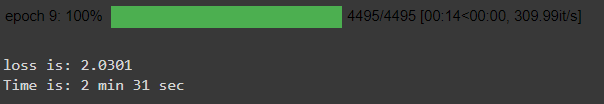

Без side_context'a лосс падает до 2.0301.   
С side_context = 1 - до 1.7192  
C side_context = 2 - до 1.5881  
C side_context = 3 - до 1.5124



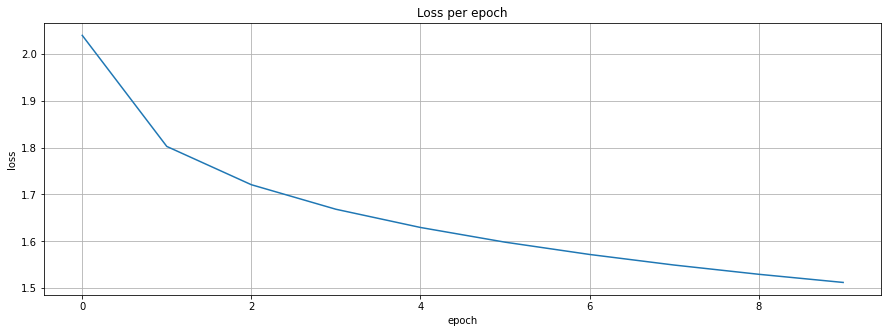

In [8]:
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.plot(loss_list)
plt.title('Loss per epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.show()

In [9]:
net.cpu()
with torch.no_grad():
    correct_cnt = 0
    for ftr, true_label in tqdm(zip(data_set.valid[:, :-1], data_set.valid[:, -1]), total=data_set.valid.shape[0]):
        ftr = torch.from_numpy(ftr).float()
        output = net.forward(ftr)
        correct_cnt += (output.argmax().item() == true_label)
        
    print("Total frame accuracy is {:.3f}".format(correct_cnt / data_set.valid.shape[0]))


Total frame accuracy is 0.547


Без side_context'a ACCURACY =  0.425  
С side_context = 1 ACCURACY =  0.498  
С side_context = 2 ACCURACY =  0.527  
C side_context = 3 ACCURACY =  0.547


In [10]:
class_correct = [0 for x in range(len(phones_dict.keys()))]
class_total = [0 for x in range(len(phones_dict.keys()))]
net.cpu()
with torch.no_grad():
    for ftr, true_label in tqdm(zip(data_set.valid[:, :-1], data_set.valid[:, -1]), total=data_set.valid.shape[0]):
        ftr = torch.from_numpy(ftr).float()
        output = net.forward(ftr)
        predict_label = output.argmax().item()
        
        class_correct[predict_label] += (predict_label == int(true_label))
        class_total[int(true_label)] += 1

for idx, phone in enumerate(phones_dict.keys()):
    if class_total[idx]:
        print('{:3s}: {:.2f} : {}/{}'.format(phone, class_correct[idx] / class_total[idx], \
                                                     class_correct[idx], class_total[idx]))


SIL: 0.95 : 21166/22200
SPN: 0.00 : 0/581
AA0: 0.00 : 0/43
AA1: 0.42 : 721/1706
AA2: 0.00 : 0/87
AE0: 0.00 : 0/36
AE1: 0.45 : 1626/3645
AE2: 0.01 : 1/123
AH0: 0.40 : 2307/5802
AH1: 0.27 : 507/1901
AH2: 0.00 : 0/48
AO0: 0.00 : 0/35
AO1: 0.45 : 889/1979
AO2: 0.00 : 0/60
AW0: 0.00 : 0/5
AW1: 0.33 : 380/1154
AW2: 0.03 : 1/32
AY0: 0.00 : 0/36
AY1: 0.65 : 1953/3015
AY2: 0.02 : 4/186
B  : 0.21 : 339/1596
CH : 0.32 : 284/892
D  : 0.33 : 1281/3925
DH : 0.20 : 401/1995
EH0: 0.00 : 0/47
EH1: 0.35 : 996/2857
EH2: 0.00 : 0/103
ER0: 0.51 : 1340/2614
ER1: 0.38 : 346/921
ER2: 0.07 : 1/15
EY0: 0.00 : 0/25
EY1: 0.52 : 1230/2383
EY2: 0.00 : 0/117
F  : 0.65 : 1561/2387
G  : 0.12 : 95/806
HH : 0.39 : 845/2169
IH0: 0.18 : 450/2542
IH1: 0.26 : 640/2444
IH2: 0.00 : 0/102
IY0: 0.48 : 1065/2227
IY1: 0.52 : 1239/2379
IY2: 0.00 : 0/46
JH : 0.17 : 111/650
K  : 0.61 : 1927/3147
L  : 0.61 : 2615/4279
M  : 0.48 : 1508/3164
N  : 0.64 : 3877/6053
NG : 0.48 : 620/1280
OW0: 0.02 : 4/194
OW1: 0.38 : 759/2019
OW2: 0.00 : 

### Распознавание по словарю с помощью нейронки

In [11]:
# теперь будем распознавать по словарю, состоящему из конечных слов
# для этого нужно загрузить файл лексикона, который определяет из каких фонем состоят наши слова
def load_lexicon_dict(lexicon_file):
    lexicon_dict = {}
    with open(lexicon_file, encoding='utf-8') as fn:
        for line in fn:
            line = line.strip().split()
            lexicon_dict[line[0]] = line[1:]
    return lexicon_dict

In [12]:
class AcousticModel:
    def __init__(self, phone_name, phone_index, priors_list):
        self.phone_name = phone_name
        self.phone_index = phone_index
        self.phone_prior = priors_list[phone_index]
        
    def distance(self, input_feats, nnet):
        with torch.no_grad():
            predicts = nnet.forward(torch.tensor(input_feats, dtype=torch.float32))
            softmax = torch.nn.functional.softmax(predicts, dim=0)
        return -np.log(softmax[self.phone_index].item() / self.phone_prior)

class State:
    def __init__(self, model, index):  
        self.model = model                     # вектор признаков узла
        self.is_final = False                  # является ли этот узел финальнвм в слове
        self.word = None                       # слово эталона (назначается только для финального узла)
        self.best_token = None                 # лучший токен (по минимуму дистанции) в узле
        self.current_word = None               # текущее слово эталона
        self.next_states = []                  # список следующих узлов
        self.index = index                     # индекс узла 

        
def load_graph(lexicon_dict, phones_dict, priors_list):
    start_state = State(None, 0)
    graph = [start_state, ]
    state_index = 1
    for word in lexicon_dict.keys():
        previous_state = start_state
        for phone in lexicon_dict[word]:
            state = State(AcousticModel(phone, phones_dict[phone], priors_list), state_index)
            state.current_word = word           # слово эталона теперь будет храниться в каждом узле
            state.next_states.append(state)     # add loop
            previous_state.next_states.append(state)
            previous_state = state 
            graph.append(state)
            state_index += 1
        if state:
            state.word = word
            state.is_final = True
    return graph

In [13]:
class Token:
    def __init__(self, state, dist=0.0, word=""):
        self.state = state       # стейт графа, в котором токен находится в текущий момент
        self.dist = dist         # общая накопленная дистанция пути, пройденного токеном
        self.word = word         # слово, которое распозналось токеном
        self.alive = True


def beam_pruning(next_tokens, threshold):   
    alive_tokens = [token for token in next_tokens if token.alive]
    best_token = alive_tokens[np.argmin([token.dist for token in alive_tokens if token.alive])]
    for token in next_tokens:
        if token.dist > best_token.dist + threshold:
            token.alive = False
    return next_tokens


def state_pruning(next_tokens):
    for i in range(len(next_tokens)): 
        state_index = next_tokens[i].state.index
        if not graph[state_index].best_token:
            graph[state_index].best_token = next_tokens[i]
        else:
            if next_tokens[i].dist <= graph[state_index].best_token.dist:
                graph[state_index].best_token.alive = False
                graph[state_index].best_token = next_tokens[i]
            else:
                next_tokens[i].alive = False
    for token in next_tokens:                           
        index = token.state.index                        
        if graph[index].best_token:                     
            graph[index].best_token = None              
    return next_tokens


def recognize(filename, features, graph, nnet, recognition_results, beam_threshold):

    start_state = graph[0]
    active_tokens = [Token(start_state), ]
    next_tokens = []
    features = np.vstack((features[:side_context], features))
    features = np.vstack((features, features[-side_context:]))
    
    for frame in range(side_context, len(features) - side_context):
        ftr_frame = features[frame - side_context : frame + side_context + 1].ravel()
        for token in active_tokens:
            if token.alive:
                for transition_state in token.state.next_states:
                    new_token = Token(transition_state, token.dist, token.word)
                    new_token.dist += transition_state.model.distance(ftr_frame, nnet)
                    next_tokens.append(new_token)
        # state and beam prunings:
        next_tokens = state_pruning(next_tokens)         
        next_tokens = beam_pruning(next_tokens, beam_threshold) 

        active_tokens = next_tokens
        next_tokens = []                                     
        
    # поиск финальных токенов:
    final_tokens = []
    for token in active_tokens:
        if token.state.is_final and token.alive:
            final_tokens.append(token)

    # если нет финальных, то берем лучший из выживших:
    if len(final_tokens) != 0:
        win_token = final_tokens[np.argmin([token.dist for token in final_tokens])]
    else:
        alive_tokens = [token for token in active_tokens if token.alive]
        win_token = alive_tokens[np.argmin([token.dist for token in alive_tokens])]
        win_token.state.word = win_token.state.current_word

    # вывод результата
    print(f"result: {filename:<27} ==> {win_token.state.word}")

    # совпадает ли запись с полученным эталоном:  
    record_word = filename.split('_')[0]
    etalon_word = win_token.state.word.split('_')[0]
    recognition_results.append(etalon_word.lower() == record_word)

    return recognition_results

In [14]:
def run_recognizer(records_data_dict, graph, nnet, beam_threshold=10):
    start_time = time.time()
    recognition_results = []

    for filename in records_data_dict.keys():    
        recognition_results = recognize(filename,
                                        records_data_dict[filename],
                                        graph, nnet,
                                        recognition_results, beam_threshold)

    print("-" * 60)
    print(f"WER is: {(1 - sum(recognition_results)/len(recognition_results))*100:.2f}%")
    print(f"Total time is: {time.time() - start_time:.2f} sec")
    print("-" * 60)

### Запустим распознавание на базе YES_NO

In [15]:
lexicon_file = 'data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/yes_no/records")

run_recognizer(records_data_dict, graph, net.cpu(), beam_threshold=100)


result: no_ad89eb1e_nohash_0        ==> NO
result: yes_ff63ab0b_nohash_0       ==> YES
result: no_49af4432_nohash_0        ==> NO
result: yes_fc94edb0_nohash_0       ==> YES
result: yes_fe1916ba_nohash_0       ==> YES
result: no_4abb2400_nohash_0        ==> NO
result: no_41474817_nohash_0        ==> NO
result: yes_39a6b995_nohash_0       ==> YES
result: no_4394fc7c_nohash_0        ==> NO
result: yes_39a12648_nohash_0       ==> YES
------------------------------------------------------------
WER is: 0.00%
Total time is: 1.75 sec
------------------------------------------------------------


Без контекста:  
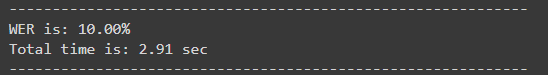

С контекстом (2):  
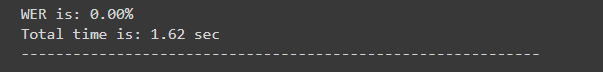

### Запустим распознавание на базе Digits

In [16]:
lexicon_file = 'data/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/digits/records")

run_recognizer(records_data_dict, graph, net.cpu(), beam_threshold=50)


result: one_fc2411fe_nohash_0       ==> NINE
result: nine_ccea893d_nohash_0      ==> NINE
result: one_ffa76c4a_nohash_0       ==> FOUR
result: two_fb2f3242_nohash_0       ==> TWO
result: six_ffbb695d_nohash_0       ==> SIX
result: seven_fd32732a_nohash_0     ==> SEVEN
result: eight_da584bc0_nohash_4     ==> EIGHT
result: seven_fe5c4a7a_nohash_0     ==> SEVEN
result: four_fce65496_nohash_0      ==> FOUR
result: eight_daf230ac_nohash_0     ==> EIGHT
result: five_f852895b_nohash_0      ==> FIVE
result: nine_fbe51750_nohash_0      ==> NINE
result: four_ffbb695d_nohash_0      ==> FOUR
result: zero_f852895b_nohash_0      ==> ZERO
result: three_fce96bac_nohash_0     ==> THREE
result: zero_f92e49f3_nohash_3      ==> ZERO
result: two_fce65496_nohash_0       ==> TWO
result: six_ffd2ba2f_nohash_0       ==> SIX
result: five_ffd2ba2f_nohash_0      ==> FIVE
result: three_feb1d305_nohash_0     ==> THREE
------------------------------------------------------------
WER is: 10.00%
Total time is: 13.32 

Без контекста:  
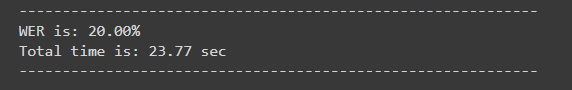

С контекстом (3)   
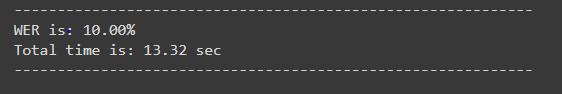

### <b>Задание №1</b> (5 баллов):
Реализовать контексты для входных признаков путем конкатенации кадров слева и справа от текущего. Не забудьте поддержать это и в функции распознавания. Насколько улучшилось качество на дата сетах?

![](https://drive.google.com/uc?export=view&id=1ft0z6CPhX20cJnA373uLoYwHPEagaKyo)

На "yes_no" уже при side_context = 2 WER стал 0%.  
На "digits" при side_context = 3 WER стал 5%.

### <b>Задание №2</b> (5 баллов):
Повысить качество классификации фонем за счет улучшения архитектуры нейронной сети, оптимизатора, других речевых признаков и т.п. Составить небольшой отчет на основе результатов перебора использованных способов. 

In [17]:
class MyNet(torch.nn.Module):

    def __init__(self, input_dim, output_dim):
        super(MyNet, self).__init__()
        # params:
        input_dim = input_dim       # размерность входных признаков
        n_nodes_hl1 = 512
        n_nodes_hl2 = 512
        n_nodes_hl3 = 512
        n_nodes_hl4 = 512
        output_dim = output_dim     # количество выходных классов (фонем)
        # FC and DO layers:
        self.fc1 = nn.Linear(input_dim, n_nodes_hl1)
        self.do1 = nn.Dropout(0.25)
        self.fc2 = nn.Linear(n_nodes_hl1, n_nodes_hl2)
        self.do2 = nn.Dropout(0.20)
        self.fc3 = nn.Linear(n_nodes_hl2, n_nodes_hl3)
        self.do3 = nn.Dropout(0.20)
        self.fc4 = nn.Linear(n_nodes_hl3, n_nodes_hl4)
        self.fc5 = nn.Linear(n_nodes_hl4, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.do1(x)
        x = torch.relu(self.fc2(x))
        x = self.do2(x)
        x = torch.relu(self.fc3(x))
        x = self.do3(x)
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return (x)

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load data:
data_set = CommonDataSet(data_list, device)

batch_size = 256

# training network model:
start = time.time() 
net = MyNet(input_dim=(data_list[0].shape[0] - 1),
            output_dim=len(phones_dict.keys())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4, amsgrad=True, weight_decay=0.00001)
loss_list = []

print('TRAINIG IS STARTED...')
for epoch in range(10):
    running_loss = 0
    counter = 0
    for batch_xs, batch_ys in tqdm(data_set.next_batch(batch_size), \
                                   total=data_set.num_batches(batch_size), \
                                   desc='epoch {}'.format(epoch)):
        optimizer.zero_grad()
        output = net(batch_xs)

        loss = criterion(output, batch_ys)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        counter += 1
        
    print('loss is: {:.4f}'.format((running_loss / counter)))
    loss_list.append(running_loss / counter)
    
end = time.time()
minutes = (end - start) // 60
seconds = np.mod((end - start), 60)
print('Time is: {} min {} sec'.format(int(minutes), int(seconds)))

TRAINIG IS STARTED...



loss is: 2.1853



loss is: 1.8908



loss is: 1.8136



loss is: 1.7659



loss is: 1.7328



loss is: 1.7058



loss is: 1.6828



loss is: 1.6646



loss is: 1.6495



loss is: 1.6355
Time is: 1 min 59 sec


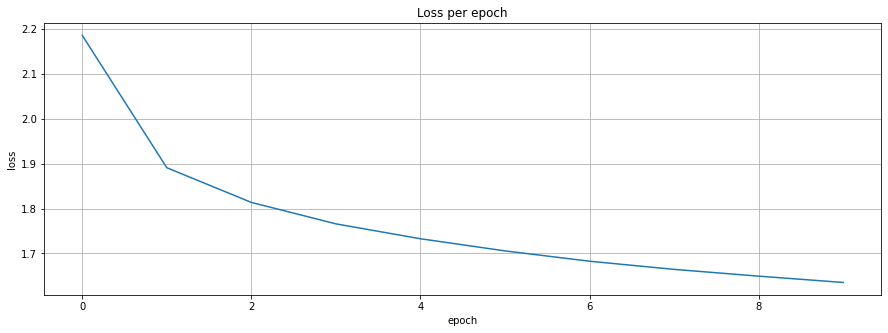

In [19]:
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.plot(loss_list)
plt.title('Loss per epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.show()

In [20]:
net.cpu()
net.eval()
with torch.no_grad():
    correct_cnt = 0
    for ftr, true_label in tqdm(zip(data_set.valid[:, :-1], data_set.valid[:, -1]), total=data_set.valid.shape[0]):
        ftr = torch.from_numpy(ftr).float()
        # output = net.forward(ftr.reshape(1,ftr.shape[0]))
        output = net.forward(ftr)
        correct_cnt += (output.argmax().item() == true_label)
    print("Total frame accuracy is {:.3f}".format(correct_cnt / data_set.valid.shape[0]))


Total frame accuracy is 0.554


In [21]:
lexicon_file = 'data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/yes_no/records")

run_recognizer(records_data_dict, graph, net.cpu(), beam_threshold=100)


result: no_ad89eb1e_nohash_0        ==> NO
result: yes_ff63ab0b_nohash_0       ==> YES
result: no_49af4432_nohash_0        ==> NO
result: yes_fc94edb0_nohash_0       ==> YES
result: yes_fe1916ba_nohash_0       ==> YES
result: no_4abb2400_nohash_0        ==> NO
result: no_41474817_nohash_0        ==> NO
result: yes_39a6b995_nohash_0       ==> YES
result: no_4394fc7c_nohash_0        ==> NO
result: yes_39a12648_nohash_0       ==> YES
------------------------------------------------------------
WER is: 0.00%
Total time is: 3.45 sec
------------------------------------------------------------


In [22]:
lexicon_file = 'data/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/digits/records")

run_recognizer(records_data_dict, graph, net.cpu(), beam_threshold=100)


result: one_fc2411fe_nohash_0       ==> ONE
result: nine_ccea893d_nohash_0      ==> NINE
result: one_ffa76c4a_nohash_0       ==> FOUR
result: two_fb2f3242_nohash_0       ==> TWO
result: six_ffbb695d_nohash_0       ==> SIX
result: seven_fd32732a_nohash_0     ==> SEVEN
result: eight_da584bc0_nohash_4     ==> EIGHT
result: seven_fe5c4a7a_nohash_0     ==> SEVEN
result: four_fce65496_nohash_0      ==> FOUR
result: eight_daf230ac_nohash_0     ==> EIGHT
result: five_f852895b_nohash_0      ==> FIVE
result: nine_fbe51750_nohash_0      ==> NINE
result: four_ffbb695d_nohash_0      ==> FOUR
result: zero_f852895b_nohash_0      ==> ZERO
result: three_fce96bac_nohash_0     ==> THREE
result: zero_f92e49f3_nohash_3      ==> ZERO
result: two_fce65496_nohash_0       ==> TWO
result: six_ffd2ba2f_nohash_0       ==> SIX
result: five_ffd2ba2f_nohash_0      ==> FIVE
result: three_feb1d305_nohash_0     ==> THREE
------------------------------------------------------------
WER is: 5.00%
Total time is: 36.38 se

Добавление нейронов в слои, измененние параметров оптимайзера и добввление дропаута позволило увеличить total frame accuracy до 0.554, а WER на digits упал до 5%